# Il metodo di Galerkin per equazioni paraboliche con diffusione e trasporto non costanti

Il notebook ha la seguente struttura:
- Introduzione teorica all'equazione di evoluzione dei dischi e alla discretizzazione di Galerkin
- Definizioni di griglia, elementi finiti, calcolo delle matrici $M$ e $A$, integratore temporale di Crank-Nicolson 
- Calcolo della soluzione esatta a partire dalla soluzione fondamentale dell'equazione (con possibili modifiche per stabilità numerica)


# Introduzione teorica

### L'equazione di evoluzione dei dischi
L'obiettivo di questo progetto è di risolvere la seguente equazione parabolica nella variabile $\Sigma$:

$$\frac{\partial \Sigma}{\partial t} = \frac{3}{r}\frac{\partial}{\partial r}r^{1/2}\frac{\partial}{\partial r}r^{1/2}\nu \Sigma.$$

$\Sigma(r,t)$ rappresenta la densità superficiale di massa di un disco di accrescimento assialmente simmetrico, $\nu = Ar^{\alpha}$ descrive la viscosità (data nei dischi astronomici dall'interazione tra mulinelli di turbolenza) che si prende come una legge di potenza dove alcuni indici di interesse sono $\alpha = 1/2, -3/10$. Con questa scelta l'equazione è lineare e otteniamo:

$$\frac{\partial \Sigma}{\partial t} = \frac{3A}{r}\frac{\partial}{\partial r}r^{1/2}\frac{\partial}{\partial r}r^{\alpha+1/2} \Sigma.$$

L'equazione diventa più trattabile passando alla variabile $u=2\pi r \Sigma$, $\Sigma = u/2\pi r$:

$$
\begin{align*}
\frac{\partial}{\partial t}\frac{u}{2\pi r}
&= \frac{3A}{r}\frac{\partial}{\partial r}r^{1/2}\frac{\partial}{\partial r}r^{\alpha+1/2}\frac{u}{2\pi r}\\
&= 3A\frac{\partial}{\partial r}r^{1/2}\frac{\partial}{\partial r}r^{\alpha-1/2}u
\end{align*}
$$

Scegliamo $A=1/3$ per eliminare il prefattore e semplifichiamo:

$$
\begin{align*}
\frac{\partial u}{\partial t} 
&= \frac{\partial}{\partial r}r^{1/2}\frac{\partial}{\partial r}r^{\alpha-1/2}u \\
&= \frac{\partial}{\partial r}
\left[
    r^{1/2}r^{\alpha-1/2}\frac{\partial u}{\partial r}
    +r^{1/2}\left(\frac{\partial}{\partial r}r^{\alpha-1/2}\right)u
\right]\\
&=\frac{\partial}{\partial r}
\left[r^{\alpha} \frac{\partial u}{\partial r} +
    r^{1/2}\left(\alpha-\frac{1}{2}\right)r^{\alpha-3/2} u
\right]\\
&=\frac{\partial}{\partial r}
\left[r^{\alpha} \frac{\partial u}{\partial r} +
    \left(\alpha-\frac{1}{2}\right)r^{\alpha-1} u
\right]
\end{align*}$$

### Forma canonica


Lo portiamo nella forma del Quarteroni che vuole:

$$\frac{\partial u}{\partial t} + L(u) = 0$$
$$L(u) = \frac{\partial}{\partial r}\left(-\mu\frac{\partial u}{\partial r} + b u\right)$$
e quindi 

$$
\begin{align*}
L(u)
&=\frac{\partial}{\partial r}
\left[-r^{\alpha} \frac{\partial u}{\partial r}
    -\left(\alpha-\frac{1}{2}\right)r^{\alpha-1} u
\right]
\end{align*}
$$

$$\mu = r^{\alpha}$$
$$b = -\left(\alpha - \frac{1}{2}\right)r^{\alpha-1}$$



### Coefficiente di trasporto

Notiamo che con questa convenzione, se trascuriamo $\mu$ e consideriamo $b$ costante, $b>0$ implica trasporto verso destra (onda progressiva):

$$\frac{\partial u}{\partial t} + b\frac{\partial u}{\partial r} = 0$$
$$u = u(r-t/b)$$

Un caso semplice è quello $\alpha=0$ in cui abbiamo viscosità costante e trasporto dato da
$$b=\frac{1}{2r}$$

La cosa strana però è che nonostante $b>0$ la soluzione esatta si sposta verso sinistra. Questo mostra che quando i coefficienti non sono costanti l'interpretazione non è banale.

## Il metodo di Galerkin per equazioni paraboliche

### Formulazione debole e sua approssimazione

Prendiamo l'equazione e moltiplichiamola per ogni $t>0$ per una funzione test $v=v(x)$ integrando su $\Omega$.
Lo spazio di funzioni test $V$ è lo spazio di funzioni $H^1(\Omega)$ che si annullano in $x_{min}$ e 1.

L'equazione diventa:

$$\int_{\Omega} \dot{u(t)}v\, d\Omega + a(u(t),v) = 0$$

dove

$$a(u,v) = \int_{\Omega} \left(\mu u' - b u\right)v'\, d\Omega,$$

con il punto che indica la derivata temporale, l'apostrofo la derivata spaziale.

L'approssimazione di Galerkin del problema si ottiene scegliendo in uno spazio $V_h \subset V$ a dimensione finita $N_h$ una base $\{\phi_j\}$:

$$u_h(x,t) = \sum_{j=1}^{N_h} u_j(t)\phi_j(x)$$

così che l'equazione in forma debole diventa

$$\sum_{j=1}^{N_h}\left(
    \dot{u}_j(t) \int_{\Omega} \phi_j \phi_i\, d\Omega + u_j(t) a(\phi_j,\phi_i) = 0
\right)$$

ovvero, definendo il vettore delle incognite $\mathbf{u} = (u_1(t), \dots,u_{N_h}(t))^T$, la matrice di massa $M = [\int_{\Omega} \phi_j \phi_i\,d\Omega]$ e la matrice di rigidezza $A = [a(\phi_j,\phi_i)]$ il sistema può essere riscritto nella forma

$$M\dot{\mathbf{u}(t)} + A\mathbf{u}(t) = 0$$

### Discretizzazione temporale

Discretizziamo l'equazione con il metodo di Crank-Nicolson:

$$M\frac{\mathbf{u}^{k+1}-\mathbf{u}^k}{\Delta t} + \frac{1}{2}A(\mathbf{u}^{k+1}+\mathbf{u}^k) = 0.$$

Il sistema da risolvere è:

$$K\mathbf{u}^{k+1} = \mathbf{g}$$

dove $K = M + A\Delta t/2$, $\mathbf{g} = (M - A\Delta t/2)\mathbf{u}^k$.

# Codice preliminare

### Pacchetti

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # barre di caricamento
from numpy.polynomial import Polynomial, polynomial # FE
from scipy.interpolate import lagrange # FE
from numpy.polynomial.legendre import leggauss # quadratura
from scipy.linalg import solve # non usata per ora
from scipy.sparse import csc_matrix # matrici sparse
from scipy.sparse.linalg import spsolve # risolutore sparso
from scipy.signal import convolve # metodo veloce per alcune funzioni di green
from scipy.optimize import curve_fit
from scipy.special import iv, gamma
from pathlib import Path
from scipy.interpolate import make_splrep # interpolazione
import pickle # salvataggio dati
plt.rcParams.update({ # latex
    "text.usetex": True,
    "font.family": "CM Roman"
})
import subprocess # comandi shell

### Utilità varie

In [ ]:
def quad(f,deg,a=0,b=1):
    # quadratura gaussiana
    x, w = leggauss(deg)
    x = (x+1)/2
    w /= 2
    h = (b-a)
    X = a + h*x
    I = sum(w*f(X))*h
    return I

def LTGdd(ndof,NumEl):
    #matrice local to global per condizioni al contorno di dirichlet
    N = ndof*NumEl-1
    right = np.r_[np.arange(N),-1].reshape((-1,ndof))
    left = np.r_[-1,right[:-1,-1]].reshape((-1,1))
    return np.c_[left,right]

def assemble_from_LTG(LTG,contribution):
    # costruisce M o A a partire da contributi locali
    # contribution(k,j,l) dove k e j righe e colonne, l indice di x
    matrix = np.zeros((np.max(LTG)+1,np.max(LTG)+1))
    for l in tqdm(range(LTG.shape[0]),leave=False):
        for k in range(LTG.shape[1]):
            row = LTG[l,k]
            if row<0:
                continue
            for j in range(LTG.shape[1]):
                col = LTG[l,j]
                if col<0:
                    continue
                matrix[row,col] += contribution(k,j,l)
    return matrix

def line(x,m,q):
    return m*x+q

def fix_lims(ax,condition):
    global xlim0, ylim0
    if condition:
        xlim0 = ax.get_xlim()
        ylim0 = ax.get_ylim()
    else:
        ax.set_xlim(xlim0)
        ax.set_ylim(ylim0)

### Griglia e calcolo di $M$

In [ ]:
class GRID:
    def __init__(self, a, b, NumEl, scaling="lin",ndof=1,getM=False,NgridM=100,fe=None,gaussdeg=None):
        # Inizializza una griglia per metodo di Galerkin
        # precalcola opzionalmente la matrice di massa

        if a>b:
            a, b = b, a 
        self.NumEl = NumEl 
        self.ndof = ndof
        self.DegOfFreedom = ndof*NumEl-1
        if scaling=="lin":
            self.V = np.linspace(a, b, NumEl+1)
        elif scaling=="log": # per ora non lo uso mai
            self.V = np.logspace(a, b, NumEl+1)
        self.ElemSize = np.diff(self.V) #lunghezza degli intervalli
        self.MidPoints = (self.V[:-1]+self.V[1:])/2 #punti medi

        # aggiungi nodi intermedi per elementi di grado > 1
        self.globV = self.V
        for i in range(1,ndof):
            self.globV = np.r_[self.globV,self.V[:-1]+self.ElemSize*i/ndof]
        self.globV = np.sort(self.globV)

        # precalcola la matrice di massa
        if gaussdeg is None:
            gaussdeg = ndof+1 # quadratura esatta per polinomi di grado 2*ndof
        if getM:
            p, dp, ndof = fe.Pol, fe.PolDer, fe.ndof
            grigliaref = GRID(0,1,NgridM) #la griglia per l'integrazione sull'elemento di riferimento
            self.Mlocal = np.zeros((ndof+1,ndof+1))
            for k in range(ndof+1):
                for j in range(ndof+1):
                    # integrale di phi_k phi_j
                    self.Mlocal[k,j] = grigliaref.integrate(lambda x: p[k](x)*p[j](x),deg=gaussdeg)*self.ElemSize[0] 

            # assemblaggio matrice globale
            self.LTG = LTGdd(ndof,NumEl) #già decise condizioni di Dirichlet omogenee
            contribution = lambda k, j, l: self.Mlocal[k,j] 
            self.M = assemble_from_LTG(self.LTG, contribution)
            
    def integrate(self,f,deg=1):
        # integra una funzione sulla griglia con quadratura gaussiana
        return sum([quad(f,deg,a=self.V[i],b=self.V[i+1]) for i in range(self.NumEl)])

### Elemento finito

In [ ]:
class FE:
    def __init__(self, ndof):
        self.ndof = ndof
        # nodi locali
        self.Xref = np.linspace(0,1,ndof+1)
        points = 0*self.Xref
        self.Pol = [None]*(ndof+1)
        # definisce i polinomi di Lagrange sui nodi associati
        for i in range(ndof+1):
            points[i] = 1 # il polinomio i-esimo deve valere 1 al nodo i-esimo
            pol = lagrange(self.Xref, points)
            self.Pol[i] = Polynomial(pol.coef[::-1])
            points[i] = 0 # spengo il nodo
        # calcolo derivate
        self.PolDer = [p.deriv() for p in self.Pol]

### Calcolo della matrice $A$

In [ ]:
def getA(fe,griglia,a,constantdiffusion=False,NgridA=10,gaussdeg=None):
    #calcola la matrice di rigidezza, a seconda se ci sono diffusione/trasporto non costanti spazialmente
    p, dp, ndof = fe.Pol, fe.PolDer, fe.ndof
    NumEl, xL, dx = griglia.NumEl, griglia.V[:-1], griglia.ElemSize
    LTG = LTGdd(ndof,NumEl)
    grigliaref = GRID(0,1,NgridA)
    if gaussdeg is None:
        gaussdeg = max(4,ndof) # sperimentalmente è sufficiente

    # se a non dipende da x
    if constantdiffusion:
        Alocal = np.zeros((ndof+1,ndof+1))
        local_a = lambda j, k, x: a(p[j],p[k],dp[j],dp[k])(x)
        for k in range(ndof+1):
            for j in range(ndof+1):
                Alocal[k,j] = grigliaref.integrate(lambda x: local_a(j, k, x),deg=gaussdeg)
        contribution = lambda k, j, l: Alocal[k,j] 
    # se a dipende da x
    else:
        full_a = lambda j, k, l, x: a(p[j],p[k],dp[j],dp[k],xL[l],dx[l])(x)
        contribution = lambda k, j, l: grigliaref.integrate(lambda x: full_a(j, k, l, x), deg=gaussdeg)
    
    A = assemble_from_LTG(LTG, contribution)
    return A

### Crank Nicolson

In [ ]:
def advance(u,dt,M,A):
    #calcola u+1 con crank-nickolson
    K = M + dt*A/2
    g = np.dot((M - dt*A/2),u[1:-1])
    # metodi per matrici sparse
    K, g = csc_matrix(K,dtype=float), csc_matrix(g,dtype=float).T
    unew_inner = spsolve(K,g)
    unew = np.r_[u[0],unew_inner,u[-1]]
    return unew

### Condizioni iniziali utili

In [ ]:
# condizioni non a supporto compatto
def waterbag(x,mu,sigma):
    return (x>mu-eps)*(x<mu+eps)
    
def gauss(x,A,mu,sigma):
    return A*np.exp(-(x-mu)**2/sigma**2)

# condizione iniziale che poi uso, perché a supporto compatto
def sph(q):
    # tipico kernel sph, da usare come distribuzione iniziale C^2 a supporto [-2h,2h]
    w = q*0
    c1 = (0<=q) & (q<=1/2)
    c2 = (1/2<=q) & (q<=1)
    w[c1] = 1-6*q[c1]**2+6*q[c1]**3
    w[c2] = 2*(1-q[c2])**3
    return w

def nicekernel(x,mu,h):
    return sph(np.abs(x-mu)/(2*h))

# Soluzione esatta

### Funzione di Green per l'equazione dei dischi
In variabili "standard", la soluzione dell'equazione per condizione iniziale
$$\Sigma(r,t=0) = \frac{M_0}{2\pi R_0}\delta(r-R_0)$$
per $\alpha<2$ è data da
$$\Sigma(r,t) = 
\frac{M_0(1-\alpha/2)}{\pi R_0^2 \xi^{(\alpha+1/4)} \tau}
\exp{-\frac{1+\xi^{2-\alpha}}{\tau}}
I_{1/|4-2\alpha|}\left(\frac{2\xi^{1-\alpha/2}}{\tau}\right)$$

dove 
- $M_0$ è la massa iniziale del disco
- $\xi=r/R_0$
- $\tau = t[12 A (1-\alpha/2)^2/R_0^2]$ tempo caratteristico della diffusione
ma noi ora usiamo $A=1/3$ quindi 
$$\tau = \left(\frac{2-\alpha}{R_0}\right)^2 t$$
e quindi il prefattore si semplifica a 
$$\frac{M_0}{2\pi(2-\alpha)\xi^{\alpha+1/4}t}$$
- $I_m(z)$ è la funzione di Bessel modificata di ordine $m$

La soluzione va poi convertita per la nostra variabile $u=2\pi r \Sigma$ (praticamente la massa $M$).

### Problemi di overflow/underflow: espressione asintotica

(!) Avevo riscontrato problemi che adesso sono abbastanza scomparsi cambiando alcune costanti del sistema, e in realtà ora le approssimazioni si vedono sulla convergenza. Tanto alla fine uso autoconvergenza.

Nella formula sopra, per argomenti grandi, l'esponenziale assume valori estremamente piccoli, la Bessel estremamente grandi.

Le funzioni di Bessel modificate ammettono la forma asintotica

$$I_{m}(z) \approx \frac{1}{\sqrt{2\pi z}\sqrt[4]{1+b^2}} \exp\left(-m\text{ arcsinh } b + z\sqrt{1+b^2}\right)$$

dove $b=m/z$, che per $m=1/2$ oppure prendendo la formula sopra per $b\ll 1$ diventa

$$I_{m}(z) \approx \frac{\exp z}{\sqrt{2\pi z}}$$

*indipendentemente da $m$*. Questa può sembrare un'approssimazione forte ma per $z\gtrsim 10$ il risultato è praticamente indistinguibile.

In questo modo nella funzione di Green il prodotto dell'esponenziale e della Bessel si semplifica (trascurando il denominatore dell'ultima formula) a 

$$\exp{\frac{(\xi^{1-\alpha/2}-1)^2}{\tau}} = \exp{R_0^{\alpha-2}\frac{(r^{1-\alpha/2}-R_0^{1-\alpha/2})^2}{\tau}}$$

che è la tipica forma di "gaussiana" di centro $R_0$ e larghezza $\sqrt{\tau}$ (per $\alpha\neq 0$ ovviamente non è proprio una gaussiana).

Praticamente con il senno di poi nella formula originale l'esponenziale conteneva la somma dei quadrati, mentre la funzione di Bessel il doppio prodotto.

Usando questa approssimazione quando l'argomento della Bessel supera una certa soglia, i problemi di overflow/underflow spariscono.

### Forme asintotiche Bessel

In [ ]:
def iv_asymptotic(m,z):
    # formula asintotica per z grande
    b = m/z
    amplitude = 1/(np.sqrt(2*np.pi*z)*(1+b**2)**(1/4))
    exponential = np.exp(-m*np.arcsinh(b)+z*np.sqrt(1+b**2))
    return amplitude*exponential

def iv_stupid(z):
    # formula estremamente approssimata che è quella che vado ad usare poi
    # praticamente iv_asymptotic per a (ordine della Bessel) piccolo
    # la formula è esattamente iv_asymptotic per a=1/2
    amplitude = 1/(np.sqrt(2*np.pi*z))
    exponential = np.exp(z)
    return amplitude*exponential

### Soluzione fondamentale

In [ ]:
def disckernel(r,R0,t,alpha=0,approx=True):
    #implementazione numericamente stabile che usa
    #forma asintotica semplificata per le funzioni di bessel modificate
    thresh = 10 #valore minimo di z per usare l'espressione di I(z>>1)
    xi = r/R0
    # i calcoli sono già fatti nel raggio adimensionale x
    tauu = t*(2-alpha)**2/R0**(2-alpha) # tempo caratteristico della diffusione
    amplitude = (1-alpha/2)/(np.pi*R0**2*xi**(alpha+1/4)*tauu)
    z = 2*xi**(1-alpha/2)/tauu # argomento della bessel
    besselorder = 1/np.abs(4-2*alpha)
    big = z*0 # inizializzo il termine problematico, prodotto exp*bessel
    if xi.size>1: # argomento vettoriale
        if approx:
            approx = z>=thresh
            noapprox = z<thresh
        else:
            approx = [False]*len(z)
            noapprox = [True]*len(z)
        big[approx] = np.exp(-(xi[approx]**(1-alpha/2)-1)**2/tauu[approx])/(np.sqrt(2*np.pi*z[approx]))
        # per z sotto la soglia utilizzo la formula esatta
        exponential = np.exp(-(1+xi[noapprox]**(2-alpha))/tauu[noapprox])
        bessel = iv(besselorder,z[noapprox])
        big[noapprox] = exponential*bessel
    else: #argomento scalare
        if approx:
            if z>=thresh:
                big = np.exp(-(xi**(1-alpha/2)-1)**2/tauu)/(np.sqrt(2*np.pi*z))
        else:
            exponential = np.exp(-(1+xi**(2-alpha))/tauu)
            bessel = iv(besselorder,z)
            big = exponential*bessel
    Sigma = amplitude*big
    # converto da densità a massa
    M = 2*np.pi*r*Sigma
    return M

### Soluzione esatta data una condizione iniziale

In [ ]:
def discexact(r,t,u0,grigliaconv,alpha=0,approx=False,gaussdeg=3,progress=False):
    # soluzione esatta disco, integrazione gaussiana
    if t==0:    
        return u0(r) #dà comunque problemi, meglio non usare
    else:
        y = r*0
        if progress:
            for i in tqdm(range(len(r)),leave=False):
                rvar = r[i]
                y[i] = grigliaconv.integrate(lambda R0: disckernel(rvar,R0,t,alpha=alpha,approx=approx)*u0(R0),deg=gaussdeg)
        else:
            for i in range(len(r)):
                rvar = r[i]
                y[i] = grigliaconv.integrate(lambda R0: disckernel(rvar,R0,t,alpha=alpha,approx=approx)*u0(R0),deg=gaussdeg)
        return y


# Equazione dei dischi

### Forma quadratica

In [5]:
def adisc(u,v,du,dv,xL=0,dx=1):
    #v in realtà non viene usata ma almeno c'è chiarezza
    mu = lambda r: r**alpha
    # b = lambda x: C
    b = lambda r: -(alpha-1/2)*r**(alpha-1)
    xrest = lambda r: xL+r*dx # dà x vero in funzione di x di riferimento
    return lambda r: (mu(xrest(r))*du(r)/dx-b(xrest(r))*u(r))*dv(r)

### Scan su h

In [ ]:
alpha = 0 # nu = Ar^alpha
a, b = 10, 100

T = 10
dt = T/2**8
Nsteps = int(T/dt)

figfolder = f"graphics/scan/dt10spaziale{alpha}"
Path(figfolder).mkdir(parents=True,exist_ok=True)
picklefile = f"{figfolder}/curve.pkl"

Ns = 5*np.logspace(1,3,20).astype(int)
hs = (b-a)/Ns

eps = (b-a)/50*2
mu = (b+a)/2
f0 = lambda x: nicekernel(x,mu,eps)

ndofs = np.arange(1,6)

counter = 0

out = []

with open("Yref1","rb") as f:
    exact = pickle.load(f)

if 0:
    ### calcolo Y esatta approssimata
    ndof_good = 3
    fe = FE(ndof_good)
    griglia_good = GRID(a,b,10000,ndof=ndof_good,getM=True,fe=fe)
    A = getA(fe,griglia_good,adisc,constantdiffusion=False)
    t = 0
    X_good = griglia_good.globV
    u = f0(X_good)
    ts = []
    for i in tqdm(range(Nsteps)):
        t+=dt
        u = advance(u,dt,griglia_good.M,A)
    Y_good = u
    good = {
    "X_good": X_good,
    "T": T,
    "Y_good": Y_good,
    "a": a,
    "b": b,
    "alpha": 0
}
    with open("Ygood2","wb") as f:
        pickle.dump(good,f)
else:
    with open("Ygood1","rb") as f:
        good = pickle.load(f)

for ndof in ndofs:
    fe = FE(ndof)
    us = []
    dus = []
    Ys = []
    dYs = []

    if 0:
        Yref_spline = make_splrep(exact["X"],exact["Yref"],k=ndof,s=0)
    if 1: 
        Yref_spline = make_splrep(good["X_good"],good["Y_good"],k=ndof,s=0)

    dYref_spline = Yref_spline.derivative(1)
    for j, N in enumerate(Ns):
        griglia = GRID(a,b,N,ndof=ndof,getM=True,fe=fe)
        A = getA(fe,griglia,adisc,constantdiffusion=False)

        t = 0

        X = griglia.globV
        u = f0(X)
        # Y = discexact(X,T,f0,grigliaconv,alpha=alpha,approx=False)
        Y = Yref_spline(X)
        dY = dYref_spline(X)
        Ys.append(Y)
        dYs.append(dY)

        ts = []
        fig, ((ax,axd), (axerr, axderr)) = plt.subplots(nrows=2,ncols=2,figsize=(10,10))
        ax.plot(X,u,".-C1",label="initial")
        for i in tqdm(range(Nsteps)):
            t+=dt
            ts = np.append(ts,t)
            u = advance(u,dt,griglia.M,A)
        
        us.append(u)
        u_spline = make_splrep(X,u,k=ndof,s=0)
        du_spline = u_spline.derivative(1)
        du = du_spline(X)
        dus.append(du)
        ax.plot(X,u,'.-C0',label="final")
        ax.plot(X,Y,'--r',label="exact")
        axerr.plot(X,u-Y,".-C0")

        axd.plot(X,du,'.-C0',label="final derivative")
        axd.plot(X,dY,'--r',label="exact derivative")
        axderr.plot(X,du-dY,".-C0")

        fig.suptitle(f"ndof={ndof}, N={N}")
        ax.legend()
        ax.grid()
        fix_lims(ax,(j==0))
        filename = f"{figfolder}/{counter:03d}.png"
        fig.savefig(filename)
        plt.close()
        counter += 1

        res = {
            "alpha": alpha,
            "T": T,
            "dt": dt,
            "Ns": Ns,
            "hs": hs,
            "ndof": ndof,
            "us": us,
            "dus": dus,
            "Ys": Ys,
            "dYs": dYs
        }

        if j==0:
            out.append(res)
        else:
            out[-1] = res
        with open(picklefile,"wb") as f:
            pickle.dump(out,f)

  0%|          | 0/256 [00:00<?, ?it/s]              

### qual è stato il mio workflow?
test di convergenza su 
- M
- A
- soluzione esatta (Nconv, gaussdeg)

### scan dt


In [25]:
alpha = 0 # nu = Ar^alpha
a, b = 10, 100

T = 10
dts = T/2**np.arange(1,12)
print(dts)


figfolder = f"graphics/scan/dx1temporale{alpha}"
Path(figfolder).mkdir(parents=True,exist_ok=True)
picklefile = f"{figfolder}/curve.pkl"

N = 120
h = (b-a)/N

eps = (b-a)/50*2
mu = (b+a)/2
f0 = lambda x: nicekernel(x,mu,eps)

ndofs = np.arange(1,6)

counter = 0

out = []

with open("Yref1","rb") as f:
    exact = pickle.load(f)

with open("Ygood1","rb") as f:
    good = pickle.load(f)

for ndof in ndofs:
    fe = FE(ndof)
    us = []
    dus = []
    Ys = []
    dYs = []

    if 0:
        Yref_spline = make_splrep(exact["X"],exact["Yref"],k=ndof,s=0)
    if 1: 
        Yref_spline = make_splrep(good["X_good"],good["Y_good"],k=ndof,s=0)

    dYref_spline = Yref_spline.derivative(1)

    griglia = GRID(a,b,N,ndof=ndof,getM=True,fe=fe)
    A = getA(fe,griglia,adisc,constantdiffusion=False)

    t = 0

    X = griglia.globV
    # Y = discexact(X,T,f0,grigliaconv,alpha=alpha,approx=False)
    Y = Yref_spline(X)
    dY = dYref_spline(X)

    ts = []

    for j, dt in enumerate(dts):
        Ys.append(Y)
        dYs.append(dY)
        u = f0(X)
        fig, ((ax,axd), (axerr, axderr)) = plt.subplots(nrows=2,ncols=2,figsize=(10,10))
        ax.plot(X,u,".-C1",label="initial")
        Nsteps = int(T/dt)
        for i in tqdm(range(Nsteps)):
            t+=dt
            ts = np.append(ts,t)
            u = advance(u,dt,griglia.M,A)
        us.append(u)
        u_spline = make_splrep(X,u,k=ndof,s=0)
        du_spline = u_spline.derivative(1)
        du = du_spline(X)
        dus.append(du)
        ax.plot(X,u,'.-C0',label="final")
        ax.plot(X,Y,'--r',label="exact")
        axerr.plot(X,u-Y,".-C0")

        axd.plot(X,du,'.-C0',label="final derivative")
        axd.plot(X,dY,'--r',label="exact derivative")
        axderr.plot(X,du-dY,".-C0")

        fig.suptitle(f"ndof={ndof}, {Nsteps} timesteps")
        ax.legend()
        ax.grid()
        fix_lims(ax,(j==0))
        filename = f"{figfolder}/{counter:03d}.png"
        fig.savefig(filename)
        plt.close()
        counter += 1

        res = {
            "alpha": alpha,
            "T": T,
            "ts": ts,
            "ndof": ndof,
            "us": us,
            "dus": dus,
            "Ys": Ys,
            "dYs": dYs
        }

        if j==0:
            out.append(res)
        else:
            out[-1] = res
        with open(picklefile,"wb") as f:
            pickle.dump(out,f)

[5.0000000e+00 2.5000000e+00 1.2500000e+00 6.2500000e-01 3.1250000e-01
 1.5625000e-01 7.8125000e-02 3.9062500e-02 1.9531250e-02 9.7656250e-03
 4.8828125e-03]


100%|██████████| 2048/2048 [00:25<00:00, 81.52it/s]


### filmini soluzione esatta

2.499975


  2%|▏         | 6/256 [00:07<04:54,  1.18s/it] 


KeyboardInterrupt: 

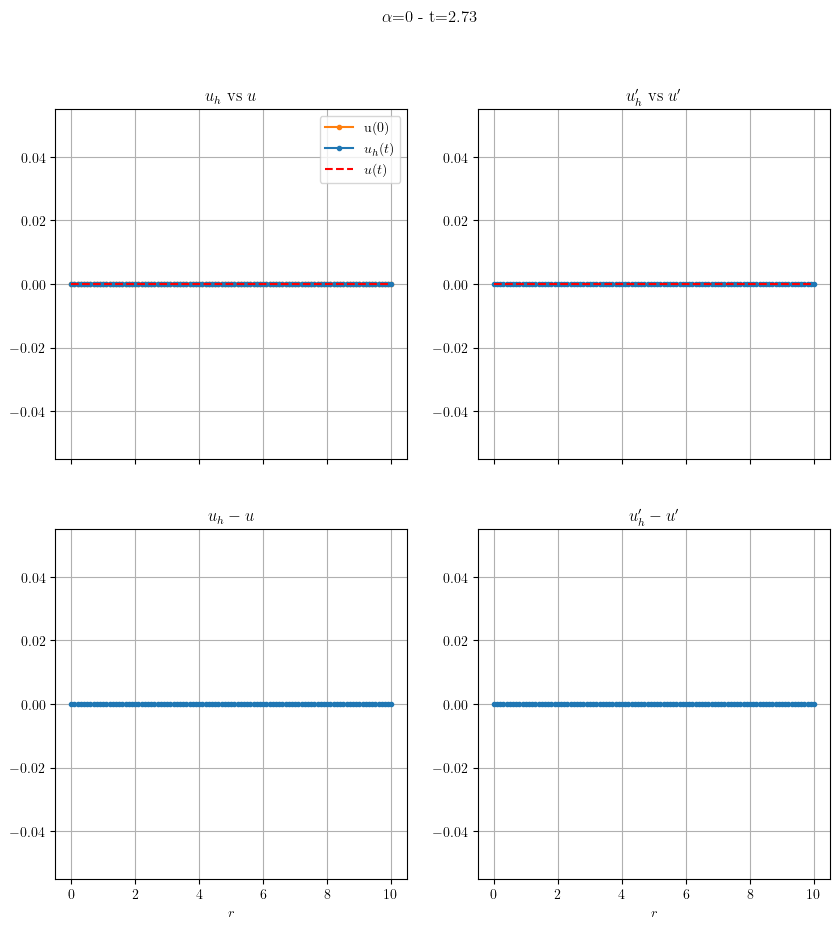

In [67]:
alpha = 0 # nu = Ar^alpha
a, b = 0.0001, 10

T = 100
dt = T/2**8
Nsnap = 200
dtplot = T/Nsnap


figfolder = f"graphics/filmini/alpha{alpha}Pe"
Path(figfolder).mkdir(parents=True,exist_ok=True)
picklefile = f"{figfolder}/curve.pkl"



eps = (b-a)/50*8
mu = (b+a)/2
mu = 0.01
eps = 0.002
f0 = lambda x: nicekernel(x,mu,eps)

N = 100
h = (b-a)/N
Pe = h/(4*mu)
print(Pe)

ndof = 1

counter = 0

out = []

with open("Yref1","rb") as f:
    exact = pickle.load(f)

with open("Ygood1","rb") as f:
    good = pickle.load(f)

fe = FE(ndof)

Yexact_spline = make_splrep(exact["X"],exact["Yref"],k=ndof,s=0)
Ygood_spline = make_splrep(good["X_good"],good["Y_good"],k=ndof,s=0)

dYexact_spline = Yexact_spline.derivative(1)
dYgood_spline = Ygood_spline.derivative(1)

griglia = GRID(a,b,N,ndof=ndof,getM=True,fe=fe)
A = getA(fe,griglia,adisc,constantdiffusion=False)

t = 0

X = griglia.globV

ts = []

u = f0(X)

Nsteps = int(T/dt)
cycle = 0
grigliaconv = GRID((b+a)/2-2*eps,(b+a)/2+2*eps,10)

for i in tqdm(range(Nsteps)):
    t+=dt
    ts = np.append(ts,t)
    u = advance(u,dt,griglia.M,A)

    if np.floor(t/dtplot) > cycle:
        Yexact = discexact(X,t,f0,grigliaconv,alpha=alpha,approx=True)
        if Yexact[0] > 0.1 or Yexact[-1] > 0.1:
            break
        Yexact_spline = make_splrep(X,Yexact,k=ndof,s=0)
        dYexact = Yexact_spline.derivative(1)(X)

        cycle += 1
        fig, ((ax,axd), (axerr1, axderr1)) = plt.subplots(nrows=2,ncols=2,figsize=(10,10),sharex=True)
        ax.plot(X,f0(X),".-C1",label="u(0)")
        u_spline = make_splrep(X,u,k=ndof,s=0)
        du_spline = u_spline.derivative(1)
        du = du_spline(X)

        ax.plot(X,u,'.-C0',label="$u_h(t)$")
        ax.plot(X,Yexact,'--r',label="$u(t)$")
        axerr1.plot(X,u-Yexact,".-C0")
        axerr1.set_xlabel("$r$")

        axd.plot(X,du,'.-C0',label="$u'_h(t)$")
        axd.plot(X,dYexact,'--r',label="$u'(t)")
        axderr1.plot(X,du-dYexact,".-C0")
        axderr1.set_xlabel("$r$")

        ax.set_title("$u_h$ vs $u$")
        axd.set_title("$u'_h$ vs $u'$")
        axerr1.set_title("$u_h-u$")
        axderr1.set_title("$u'_h-u'$")

        fig.suptitle(f"$\\alpha$={alpha} - t={t:0.2f}")
        ax.legend()
        ax.legend()
        ax.grid()
        axd.grid()
        axderr1.grid()
        axerr1.grid()
        # fix_lims(ax,(j==0))
        filename = f"{figfolder}/{counter:03d}.png"
        plt.tight_layout()
        fig.savefig(filename)
        plt.close()
        counter += 1

video_name = f"{figfolder}.mp4"
subprocess.Popen([
    "ffmpeg","-framerate","16", "-i",f"{figfolder}/%03d.png", "-pix_fmt","yuv420p",video_name, "-y"
])

In [ ]:
rmin = 10 #raggio minimo
alpha = 0.5# nu = Ar^alpha
a, b = 20, 80

T = 10
dt = T/2**10
Nsteps = int(T/dt)
dt_btw_saves = T/2**8
time_scan = True

figfolder = "graphics/disco_esatta"
Path(figfolder).mkdir(parents=True,exist_ok=True)
picklefile = f"{figfolder}/data.pkl"

N = 100
hs = (b-a)/Ns

eps = (b-a)/50*2
mu = (b+a)/2
f0 = lambda x: nicekernel(x,mu,eps)

grigliaconv = GRID((b+a)/2-2*eps,(b+a)/2+2*eps,10)

ndofs = np.arange(1,3)
fe = FE(ndof)

counter = 0
out = []

with open("Yref1","rb") as f:
    exact = pickle.load(f)
for ndof in ndofs:
    fe = FE(ndof)
    griglia = GRID(a,b,N,ndof=ndof,getM=True,fe=fe)
    A = getA(fe,griglia,adisc,constantdiffusion=False)

    Yref_spline = make_splrep

    t = 0
    snapshots = []
    ts = []

    X = griglia.globV
    u = f0(X)

    cycle = 0
    for i in tqdm(range(Nsteps)):
        t+=dt
        u = advance(u,dt,griglia.M,A)
        if time_scan and np.floor(t/dt_btw_saves) >= cycle:
            ts.append(t)
            snapshots.append(u)
            cycle += 1
    Y = discexact(X,t,f0,grigliaconv,alpha=alpha,approx=True)
    print(np.max(u)/np.max(Y))
    fig, ax = plt.subplots()
    # ax.plot(X,f0(X),label="initial")
    ax.plot(X,u,label="final")
    ax.plot(X,Y,'--r',label="exact")
    ax.set_title(f"ndof={ndof}, N={N}")
    ax.legend()
    ax.grid()
    # fix_lims(ax,(i==0))
    filename = f"{figfolder}/{counter:03d}.png"
    fig.savefig(filename)
    plt.close()
    counter += 1
    
    res = {
        "ts": ts,
        "snapshots": snapshots,
    }
    out.append(res)

with open(picklefile,"wb") as f:
    pickle.dump(out,f)

100%|██████████| 1024/1024 [00:00<00:00, 1059.76it/s]


1.001973208044236


100%|██████████| 1024/1024 [00:01<00:00, 523.95it/s]


1.0022635496482368


### Debugging errore soluzione esatta

### Generazione soluzione fiduciale

In [51]:
T = 10

eps = (b-a)/50*2
mu = (b+a)/2
f0 = lambda x: nicekernel(x,mu,eps)

counter = 0
out = []
ndof = 1
fe = FE(ndof)
griglia = GRID(a,b,N,ndof=ndof,getM=True,fe=fe)
X = griglia.globV

N = 1000
rmin = 10 #raggio minimo 
rmax = 100
alpha = 0 # nu = Ar^alpha
 
a, b = rmin, rmax

grigliaconvref = GRID((b+a)/2-2*eps,(b+a)/2+2*eps,1000)
Yref = discexact(X,T,f0,grigliaconvref,alpha=alpha,approx=False,gaussdeg=6,progress=True)


In [ ]:
out = {
    "X_good": X_good,
    "T": T,
    "Y_good": Y_good,
    "a": a,
    "b": b,
    "alpha": 0
}
if 0:
    with open("Ygood1","wb") as f:
        pickle.dump(out,f)

In [ ]:
Nconvs = 5*np.logspace(0,2,10).astype(int)
Nconvs = [200]
degs = np.arange(1,5)
out = []
include_err0 = 1
include_err1 = 1
for Nconv in Nconvs:
    grigliaconv = GRID((b+a)/2-2*eps,(b+a)/2+2*eps,Nconv)
    errs = []
    for deg in tqdm(degs,leave=False):
        Y = discexact(X,t,f0,grigliaconv,alpha=alpha,approx=False,gaussdeg=deg,progress=True)
        err = np.sqrt(np.sum(include_err0*(Y-Yref)**2)+include_err1*())
        errs.append(err)
    errs = np.array(errs)
    res = {
        "errs": errs,
        "Nconv": Nconv
    }
    out.append(res)


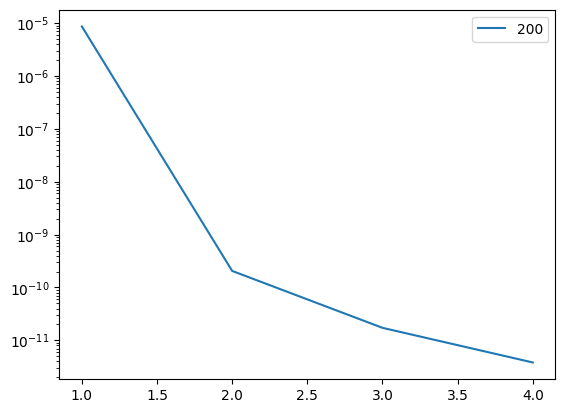

In [44]:
fig, ax = plt.subplots()
for res in out:
    ax.plot(degs,res["errs"],label=f"{res["Nconv"]}")
    ax.axhline(0)
ax.set_yscale("log")
ax.legend()
# A = getA(fe,griglia,adisc,constantdiffusion=False)

plt.show()

# Appendice

### Debugging forma quadratica analitica $\alpha=0$

Ho calcolato la forma esatta della forma quadratica per il caso $\alpha=0$ e separando i contributi di $\mu$ e $\beta$ sono riuscito a trovare un bug nel codice. 

In [ ]:
ndof = 1# grado degli elementi finiti
fe = FE(ndof)
N = 100
rmin = 10 #raggio minimo 
rmax = 100
alpha = 0 # nu = Ar^alpha
 
a, b = rmin, rmax
griglia = GRID(a,b,N,ndof=ndof,getM=True,fe=fe)

def adisc(u,v,du,dv,xL=0,dx=1):
    #v in realtà non viene usata ma almeno c'è chiarezza
    mu = lambda r: r**alpha
    # mu = lambda r: 0
    b = lambda r: -(alpha-1/2)*r**(alpha-1)
    # b = lambda r: 0
    xrest = lambda r: xL+r*dx # dà x vero in funzione di x di riferimento
    return lambda r: (mu(xrest(r))*du(r)/dx-b(xrest(r))*u(r))*dv(r)

A = getA(fe,griglia,adisc,constantdiffusion=False)

x = griglia.V
h = griglia.ElemSize[0]

# solo diffusione (matrice standard perché in questo caso è costante)
Amu = np.zeros((N+1,N+1))
for i in range(N):
    for j in range(N):
        if i==j:
            Amu[i,j] = 2/h #-1/h+ 1/(2*h**2)*(x[i-1]*np.log(x[i]/x[i-1])+x[i+1]*np.log(x[i+1]/x[i]))
        elif i==j+1:
            Amu[i,j] = -1/h #-1/(2*h) 1/(2*h**2)*x[i]*np.log(x[i]/x[j])
        elif j==i+1:
            Amu[i,j] = -1/h #+1/(2*h) 1/(2*h**2)*x[i]*np.log(x[i]/x[j])

# matrice completa
At = np.zeros((N+1,N+1))
for i in range(N):
    for j in range(N):
        if i==j:
            At[i,j] = 2/h -1/h+ 1/(2*h**2)*(x[i-1]*np.log(x[i]/x[i-1])+x[i+1]*np.log(x[i+1]/x[i]))
        elif i==j+1:
            At[i,j] = -1/h +1/(2*h) - 1/(2*h**2)*x[i]*np.log(x[i]/x[j])
        elif j==i+1:
            At[i,j] = -1/h +1/(2*h) + 1/(2*h**2)*x[i]*np.log(x[i]/x[j])

Amu = Amu[1:-1,1:-1]
At = At[1:-1,1:-1]
Ab = At-Amu
fig, ax = plt.subplots()
pos = ax.imshow(Ab-A)
fig.colorbar(pos)
plt.show()

up, center, down = [np.diag(At-A,k=k)/np.diag(Ab,k=k) for k in [-1,0,1]]

fig, ax = plt.subplots()
ax.plot(up,label="up")
ax.plot(center,label="center")
ax.plot(down,label="down")
ax.legend()
plt.show()

### Convergenza nel calcolo di A

Si vede che con quadratura di grado 4 si raggiunge sempre il plateau.

In [ ]:
fe = FE(ndof)
N = 10
rmin = 10 #raggio minimo 
rmax = 100
alpha = 1/2 # nu = Ar^alpha
 
a, b = rmin, rmax
ndofs = np.arange(1,10)
degs = np.arange(1,10)
out = []
for ndof in ndofs:
    griglia = GRID(a,b,N,ndof=ndof,getM=True,fe=fe)
    Aref = getA(fe,griglia,adisc,constantdiffusion=False,gaussdeg=10)
    errs = []
    for deg in tqdm(degs,leave=False):
        A = getA(fe,griglia,adisc,constantdiffusion=False)
        err = np.sqrt(np.sum((A-Aref)**2))
        errs.append(err)
    errs = np.array(errs)
    res = {
        "errs": errs,
        "ndof": ndof
    }
    out.append(res)


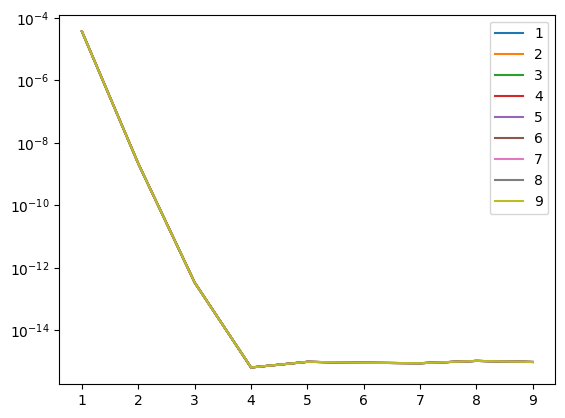

In [ ]:
fig, ax = plt.subplots()
for res in out:
    ax.plot(degs,res["errs"],label=f"{res["ndof"]}")
    ax.axhline(0)
ax.set_yscale("log")
ax.legend()
# A = getA(fe,griglia,adisc,constantdiffusion=False)

plt.show()

## Test preliminari su equazione del calore

### Soluzione esatta equazione del calore

In [ ]:
def aheat(u,v,du,dv,xL=0,dx=1):
    return lambda x: du(x)*dv(x)

def heatkernel(x,t,k):
    # funzione di green dell'equazione del calore, k diffusività
    return x*0 if t==0 else np.exp(-x**2/(4*k*t))/np.sqrt(4*np.pi*k*t)

def heatexact(x,t,k,g,grigliaconv):
    # soluzione esatta equazione del calore con integrazione gaussiana
    y = x*0
    for i in tqdm(range(len(x))):
        xvar = x[i]
        y[i] = grigliaconv.integrate(lambda y: g(y)*heatkernel(xvar-y,t,k))
    return y
    
def heatexactconv(x,t,k,g):
    # soluzione esatta equazione del calore con convoluzione di scipy
    kernel = heatkernel(x-(b-a)/2,t,k)
    G = g(X)
    return convolve(G,kernel,mode="same")/sum(kernel)

### Test su equazione del calore
La miglior condizione iniziale è quella $C^2$ a supporto compatto per velocizzare il calcolo della soluzione esatta (collo di bottiglia).

100%|██████████| 101/101 [00:00<00:00, 641.26it/s]


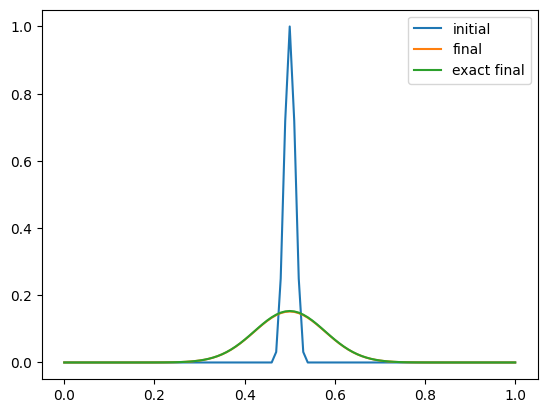

In [ ]:
ndof = 4
a, b = 0, 1
fe = FE(ndof)
griglia = GRID(a,b,25,ndof=ndof,getM=True,fe=fe)
A = getA(fe,griglia,aheat,constantdiffusion=True)

p = fe.Pol
dt = 0.00001
t = 0
eps = (b-a)/50
Nsteps = 300

# f0 = lambda x: np.exp(-(x-(a+b)/2)**2/eps**2)
# f0 = lambda x: gauss(x,(b-a)*0.4,eps)+ gauss(x, (b-a)*0.6,eps) 
f0 = lambda x: nicekernel(x,(b+a)/2,eps)
# f0 = lambda x: waterbag(x,(a+b)/2,eps)
X = griglia.globV
u = f0(X)
ts = []
fig, ax = plt.subplots()
ax.plot(X,u,label="initial")
for i in tqdm(range(Nsteps)):
    t+=dt
    ts = np.append(ts,t)
    u = advance(u,dt,griglia.M,A)
ax.plot(X,u,label="final")
k=1

grigliaconv = GRID((b+a)/2-2*eps,(b+a)/2+2*eps,5)
Y = heatexact(X,t,k,f0,grigliaconv)
ax.plot(X,Y,label="exact final")

if t==0:
    t=1
# Yc = heatexactconv(X,t,k,f0)
# ax.plot(X,Yc,label="convolve final")
ax.legend()

plt.show()

## Test convergenza su equazione del calore

### Convergenza spaziale

In [ ]:
a, b = 0, 1
dt = 2**1*1e-6
T = 2**12*1e-6
Nsteps = int(T/dt)

figfolder = "graphics/convergenza_spaziale"
Path(figfolder).mkdir(parents=True,exist_ok=True)

Ns = 5*np.logspace(1,2,10).astype(int)
hs = (b-a)/Ns

eps = (b-a)/50*2
f0 = lambda x: nicekernel(x,(b+a)/2,eps)
grigliaconv = GRID((b+a)/2-2*eps,(b+a)/2+2*eps,50)

ndofs = np.arange(1,5)
fe = FE(ndof)

k = 1

errs_ndofs = []
counter = 0
for ndof in ndofs:
    fe = FE(ndof)
    errs = []

    for j, N in enumerate(Ns):
        griglia = GRID(a,b,N,ndof=ndof,getM=True,fe=fe)
        A = getA(fe,griglia,aheat,constantdiffusion=True)
        
        t = 0

        X = griglia.globV
        u = f0(X)
        ts = []
        fig, ax = plt.subplots()
        ax.plot(X,u,label="initial")
        for i in range(Nsteps):
            t+=dt
            ts = np.append(ts,t)
            u = advance(u,dt*(b-a),griglia.M,A)
        
        Y = heatexact(X,t,k,f0,grigliaconv)
        err = np.sqrt(np.sum((u-Y)**2))
        errs.append(err)
        ax.plot(X,u,label="final")
        ax.plot(X,Y,label="exact final")
        ax.set_title(f"ndof={ndof}, N={N}")
        ax.legend()
        ax.grid()
        filename = f"{figfolder}/{counter:03d}.png"
        fig.savefig(filename)
        plt.close()
        counter += 1

    errs = np.array(errs)
    errs_ndofs.append(errs)

with open("h.pkl","wb") as f:
    pickle.dump(errs,f)

  0%|          | 0/301 [00:00<?, ?it/s]

100%|██████████| 2001/2001 [00:41<00:00, 48.67it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'h.pickle'

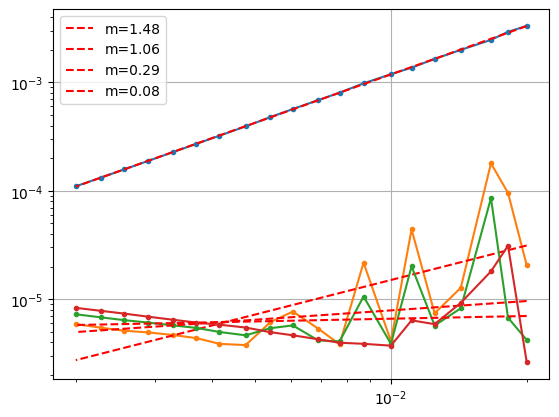

In [ ]:
with open("h.pkl","rb") as f:
    errs = pickle.load(f)

fig, ax = plt.subplots()

for errs in errs_ndofs:
    Xfit = np.log10(hs)
    Yfit = np.log10(errs)
    popt, _ = curve_fit(line,Xfit,Yfit)
    ax.plot(hs,errs,'.-')
    ax.plot(hs,10**line(Xfit,*popt),'--r',label=f"m={popt[0]:0.2f}")
ax.set_xscale("log")
ax.set_yscale("log")
ax.grid()
ax.legend()
plt.show()

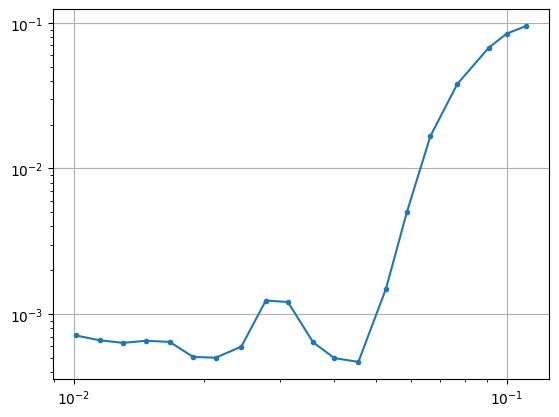

In [ ]:
fig, ax = plt.subplots()
Xfit = np.log10(hs)
Yfit = np.log10(errs)
# popt, _ = curve_fit(line,Xfit,Yfit)
ax.plot(hs,errs,'.-C0')
# ax.plot(hs,10**line(hs,*popt),'--C1')
ax.set_xscale("log")
ax.set_yscale("log")
ax.grid()
plt.show()